# Learning to encode language with Contrastive Learning

Contrastive learning of observation encodings. The goal is to have two encoders, one for the observation and one for the language description, both encoding to the same context embedding. 

Load observation-sentence pairs:

In [1]:
import json

def load_pairs(data_path):
    with open(data_path, "r") as f:
        data = json.load(f)
    pairs = []
    for step, s_data in data.items():
        if not step.startswith("Step"):
            continue
        pairs.append({
            "observation": s_data["Agent_0"]["Observation"],
            "sentence": s_data["Agent_0"]["Sentence"][1:-1]
        })
        pairs.append({
            "observation": s_data["Agent_1"]["Observation"],
            "sentence": s_data["Agent_1"]["Sentence"][1:-1]
        })
    return pairs

data_pairs = load_pairs("test_data/Sentences_Generated_P1.json")
data_pairs[0]

{'observation': [0.3566717617981794,
  0.22018956073987805,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  1.0,
  -0.4988445287954038,
  -0.25249793046375035],
 'sentence': ['Located', 'East', 'Landmark', 'South', 'West']}

Split data

In [2]:
train_data = data_pairs[:80000]
test_data = data_pairs[80000:]

In [3]:
len(test_data)

20000

Initialise the models

In [4]:
import torch
from model.modules.lm import GRUEncoder, OneHotEncoder
from model.modules.obs import ObservationEncoder

word_encoder = OneHotEncoder(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'])

lang_enc = GRUEncoder(32, word_encoder)

obs_enc = ObservationEncoder(17, 32)

Initialise loss and optimizer

In [5]:
from torch import nn, optim

criterion = nn.CrossEntropyLoss()
opt = optim.SGD(list(lang_enc.parameters()) + list(obs_enc.parameters()), lr=0.1)

Train

In [6]:
import time
import random
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt

def sample_batch(data, batch_size):
    batch = random.sample(data, batch_size)
    obs_batch = []
    sent_batch = []
    for pair in batch:
        obs_batch.append(pair["observation"])
        sent_batch.append(pair["sentence"])
    return obs_batch, sent_batch

def get_clip_loss(obs_batch, sent_batch, obs_enc, lang_enc, temp, cross_ent_loss):
    # Encode observations
    obs_tensor = torch.Tensor(np.array(obs_batch))
    context_batch = obs_enc(obs_tensor)

    # Encode sentence
    lang_context_batch = lang_enc(sent_batch)
    lang_context_batch = lang_context_batch.squeeze()

    # Compute similarity
    context_batch = context_batch / context_batch.norm(dim=1, keepdim=True)
    lang_context_batch = lang_context_batch / lang_context_batch.norm(dim=1, keepdim=True)
    sim = context_batch @ lang_context_batch.t() * temp
    mean_sim = sim.diag().mean()

    # Compute loss
    labels = torch.arange(len(obs_batch))
    loss_o = cross_ent_loss(sim, labels)
    loss_l = cross_ent_loss(sim.t(), labels)
    loss = (loss_o + loss_l) / 2
    
    return loss, mean_sim

def train(data, obs_enc, lang_enc, word_encoder, cross_ent_loss, opt, 
          n_iters=80000, batch_size=128, temp=0.07, eval_data=None, eval_evry=1000,
          sample_fn=sample_batch):
    start = time.time()
    
    train_losses = []
    eval_losses = []
    eval_sims = []
    
    for s_i in tqdm(range(n_iters)):
        opt.zero_grad()
        
        # Sample batch
        obs_batch, sent_batch = sample_fn(data, batch_size)
        
        # Compute loss
        loss, _ = get_clip_loss(obs_batch, sent_batch, obs_enc, lang_enc, temp, cross_ent_loss)

        # Backprop
        loss.backward()
        opt.step()
        
        train_losses.append(loss.item())
        
        if eval_data is not None and (s_i + 1) % eval_evry == 0:
            with torch.no_grad():
                # Sample batch
                obs_batch, sent_batch = sample_fn(eval_data, batch_size)
                
                # Get loss
                loss, sim = get_clip_loss(obs_batch, sent_batch, obs_enc, lang_enc, temp, cross_ent_loss)
                eval_losses.append(loss)
                eval_sims.append(sim)
    
    return train_losses, eval_losses, eval_sims
            

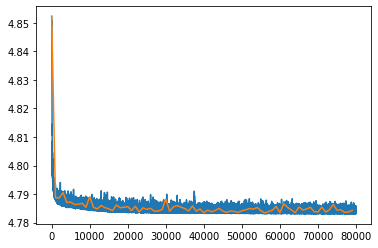

In [9]:


train_loss, eval_loss = train(train_data, obs_enc, lang_enc, word_encoder, criterion, opt, eval_data=test_data)

plt.plot(train_loss)
plt.plot(np.arange(80) * 1000, eval_loss)

Smaller context vector, Adam optim with smaller learning rate, higher temperature

100%|█████████████████████████████████████████████████████████████| 30000/30000 [03:36<00:00, 138.70it/s]


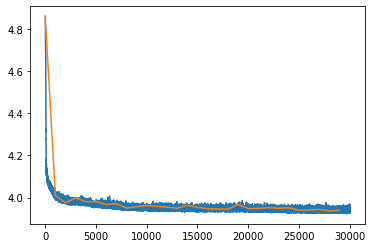

In [18]:
lang_enc = GRUEncoder(16, word_encoder)
obs_enc = ObservationEncoder(17, 16)

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(list(lang_enc.parameters()) + list(obs_enc.parameters()), lr=0.001)

train_loss, eval_loss = train(train_data, obs_enc, lang_enc, word_encoder, criterion, opt, eval_data=test_data,
                             temp=1.0, n_iters=30000)

plt.plot(train_loss)
plt.plot(np.arange(30) * 1000, eval_loss)

100%|█████████████████████████████████████████████████████████████| 20000/20000 [03:00<00:00, 110.85it/s]


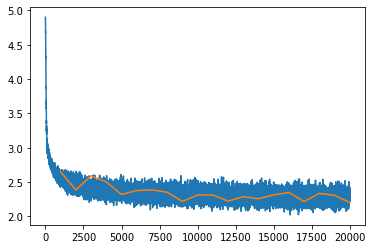

In [37]:
lang_enc = GRUEncoder(16, word_encoder)
obs_enc = ObservationEncoder(17, 16)

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(list(lang_enc.parameters()) + list(obs_enc.parameters()), 
                     lr=0.001)

train_loss, eval_loss = train(train_data, obs_enc, lang_enc, word_encoder, criterion, opt, eval_data=test_data,
                             temp=5.0, n_iters=20000)

plt.plot(train_loss)
plt.plot((np.arange(20) + 1) * 1000, eval_loss)

100%|█████████████████████████████████████████████████████████████| 20000/20000 [03:10<00:00, 104.97it/s]


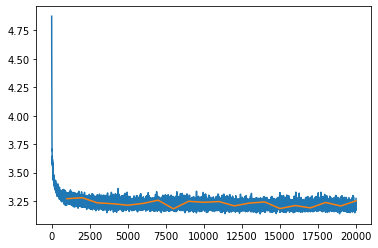

In [35]:
lang_enc = GRUEncoder(16, word_encoder)
obs_enc = ObservationEncoder(17, 16)

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(list(lang_enc.parameters()) + list(obs_enc.parameters()), 
                     lr=0.01)

train_loss, eval_loss = train(train_data, obs_enc, lang_enc, word_encoder, criterion, opt, eval_data=test_data,
                             temp=2.0, n_iters=20000)

plt.plot(train_loss)
plt.plot((np.arange(20) + 1) * 1000, eval_loss)

100%|█████████████████████████████████████| 20000/20000 [03:26<00:00, 97.06it/s]


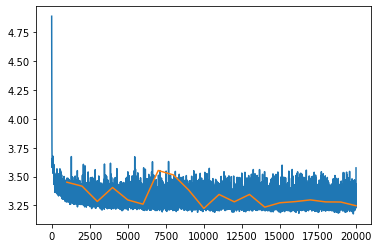

In [8]:
lang_enc = GRUEncoder(16, word_encoder)
obs_enc = ObservationEncoder(17, 16, n_hidden_layers=0)

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(list(lang_enc.parameters()) + list(obs_enc.parameters()), 
                     lr=0.01)

train_loss, eval_loss, eval_sims = train(train_data, obs_enc, lang_enc, word_encoder, criterion, opt, 
                                         eval_data=test_data, temp=2.0, n_iters=20000)

plt.plot(train_loss)
plt.plot((np.arange(20) + 1) * 1000, eval_loss)

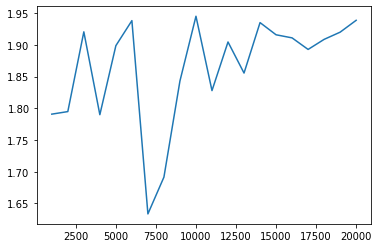

In [9]:
plt.plot((np.arange(20) + 1) * 1000, eval_sims)

### Selecting elements of mini-batches

First, we eliminate elements with the same sentence in all the data:

In [8]:
def sample_batch_nodup(data, batch_size):
    obs_batch = []
    sent_batch = []
    for b_i in range(batch_size):
        element = random.choice(data)
        obs = element["observation"]
        sent = element["sentence"]
        if sent in sent_batch:
            continue
        else:
            obs_batch.append(obs)
            sent_batch.append(sent)
    return obs_batch, sent_batch
sample_batch_nodup(data_pairs, 100)

([[0.6656765054379509,
   -0.05157421034275488,
   -0.6008975983041566,
   0.22434332167046883,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0],
  [-0.1744821036847292,
   -0.05064224533012644,
   -1.1889676962898181,
   -0.44416402844297764,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0],
  [-0.2830698438310227,
   0.5640211167745088,
   -0.17764076210816904,
   0.3436851960485801,
   1.0,
   -0.10141123935582114,
   -0.38220034794020763,
   -0.5724833485736557,
   -0.47192598028167865,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   0.0,
   1.0,
   1.0],
  [-0.24088163552011288,
   -0.6237342942736634,
   0.6893685803604463,
   0.355879504931616,
   0.0,
   1.0,
   1.0,
   0.0,
   0.0,
   1.0,
   0.6447971401987059,
   -0.546403142834842,
   1.8327116776118228e-14,
   -5.196740688157919e-15,
   1.0,
   0.5850487384830705,
   0.5334620949256739],
  [0.20897270472018775,
   -0.96

100%|█████████████████████████████████████████████████████████████| 20000/20000 [01:59<00:00, 167.10it/s]


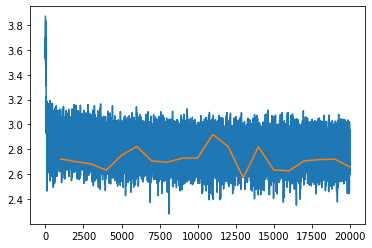

In [11]:
lang_enc = GRUEncoder(16, word_encoder)
obs_enc = ObservationEncoder(17, 16)

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(list(lang_enc.parameters()) + list(obs_enc.parameters()), 
                     lr=0.001)

train_loss, eval_loss = train(train_data, obs_enc, lang_enc, word_encoder, criterion, opt, eval_data=test_data,
                             temp=1.0, n_iters=20000, sample_fn=sample_batch_nodup)

plt.plot(train_loss)
plt.plot((np.arange(20) + 1) * 1000, eval_loss)

100%|█████████████████████████████████████████████████████████████| 20000/20000 [01:30<00:00, 221.57it/s]


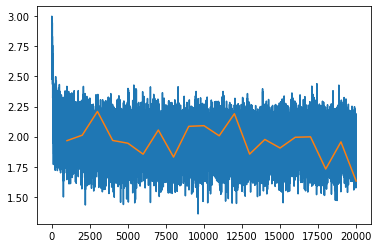

In [13]:
lang_enc = GRUEncoder(16, word_encoder)
obs_enc = ObservationEncoder(17, 16)

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(list(lang_enc.parameters()) + list(obs_enc.parameters()), 
                     lr=0.001)

train_loss, eval_loss = train(train_data, obs_enc, lang_enc, word_encoder, criterion, opt, eval_data=test_data,
                             temp=1.0, n_iters=20000, sample_fn=sample_batch_nodup, batch_size=32)

plt.plot(train_loss)
plt.plot((np.arange(20) + 1) * 1000, eval_loss)

100%|█████████████████████████████████████████████████████████████| 20000/20000 [00:59<00:00, 334.32it/s]


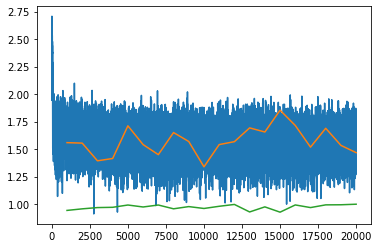

In [15]:
lang_enc = GRUEncoder(16, word_encoder)
obs_enc = ObservationEncoder(17, 16)

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(list(lang_enc.parameters()) + list(obs_enc.parameters()), 
                     lr=0.001)

train_loss, eval_loss, eval_sim = train(train_data, obs_enc, lang_enc, word_encoder, criterion, opt, 
                                        eval_data=test_data, temp=1.0, n_iters=20000, 
                                        sample_fn=sample_batch_nodup, batch_size=16)

plt.plot(train_loss)
plt.plot((np.arange(len(eval_loss)) + 1) * 1000, eval_loss)
plt.plot((np.arange(len(eval_sim)) + 1) * 1000, eval_sim)

100%|██████████████████████████████████████| 2000/2000 [00:06<00:00, 303.51it/s]


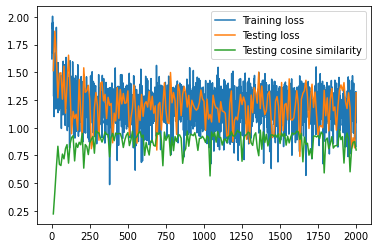

In [11]:
lang_enc = GRUEncoder(16, word_encoder)
obs_enc = ObservationEncoder(17, 16)

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(list(lang_enc.parameters()) + list(obs_enc.parameters()), 
                     lr=0.01)

train_loss, eval_loss, eval_sim = train(train_data, obs_enc, lang_enc, word_encoder, criterion, opt, 
                                        eval_data=test_data, temp=1.0, n_iters=2000, 
                                        sample_fn=sample_batch_nodup, batch_size=8, eval_evry=10)

plt.plot(train_loss, label='Training loss')
plt.plot((np.arange(len(eval_loss)) + 1) * 10, eval_loss, label='Testing loss')
plt.plot((np.arange(len(eval_sim)) + 1) * 10, eval_sim, label='Testing cosine similarity')
plt.legend()

100%|█████████████████████████████████████████████████████████████| 20000/20000 [01:03<00:00, 317.29it/s]


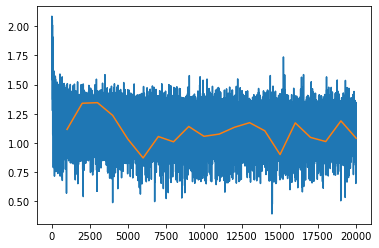

In [15]:
lang_enc = GRUEncoder(16, word_encoder)
obs_enc = ObservationEncoder(17, 16)

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(list(lang_enc.parameters()) + list(obs_enc.parameters()), 
                     lr=0.001)

train_loss, eval_loss = train(train_data, obs_enc, lang_enc, word_encoder, criterion, opt, eval_data=test_data,
                             temp=1.0, n_iters=20000, sample_fn=sample_batch_nodup, batch_size=8)

plt.plot(train_loss)
plt.plot((np.arange(20) + 1) * 1000, eval_loss)

100%|███████████████████████████████████████████████████████| 200000/200000 [10:50<00:00, 307.56it/s]


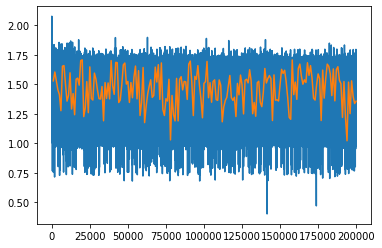

In [22]:
lang_enc = GRUEncoder(16, word_encoder)
obs_enc = ObservationEncoder(17, 16)

criterion = nn.CrossEntropyLoss()
opt = optim.Adam(list(lang_enc.parameters()) + list(obs_enc.parameters()), 
                     lr=0.001)

train_loss, eval_loss = train(train_data, obs_enc, lang_enc, word_encoder, criterion, opt, eval_data=test_data,
                             temp=0.5, n_iters=200000, sample_fn=sample_batch_nodup, batch_size=8)

plt.plot(train_loss)
plt.plot((np.arange(len(eval_loss)) + 1) * 1000, eval_loss)